## Aadhaar scan

In [2]:
import os
from PIL import Image
import pytesseract
import cv2
from matplotlib import pyplot as plt
import re

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

### Basic OCR extract

In [4]:
def extract_details(text):
    lines = text.split("\n")
    return lines


image_path = "../assets/aadhaar/Aadhar Front.jpg"
if os.path.exists(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image)

    # Extract details from the text
    details = extract_details(text)
    for data in details:
        print(data)
else:
    print(f"Image {i} not found in the directory")

17/07/2016

Issue Date :

WW FHT aQeor
M Sudarshan

- NMS Wren / DOB : 19/05/1998
4,o001LuITeD / Male

2329 4060 9712
TOD) BAM, TOMA) HOOLwirend




### Apply OCR after filtering image

- Input Image -> Convert to Grayscale -> Gaussian Blur -> Otsu's Threshold
- Notice how there are tiny specs of noise, to remove them we can perform morphological operations.
- Finally we invert the image.

Page segmentation modes:
e.g: `config="--psm 4"`
```
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.
 ```

alae Gace A.
Government of India fein
Gg aaa Agialg
Bibhuti Bhusan Mahapatra Fy
SE GIRS /DOB- 19 09/2001 &
} pay MALE 2
4
a ;
8

4691 7256 2929
VID : 9151 9141 2718 9063
HU Ze, GA ARed

TEXT:  alae Gace A. new_line Government of India fein new_line Gg aaa Agialg new_line Bibhuti Bhusan Mahapatra Fy new_line SE GIRS /DOB- 19 09/2001 & new_line } pay MALE 2 new_line 4 new_line a ; new_line 8 new_line  new_line 4691 7256 2929 new_line VID : 9151 9141 2718 9063 new_line HU Ze, GA ARed new_line 


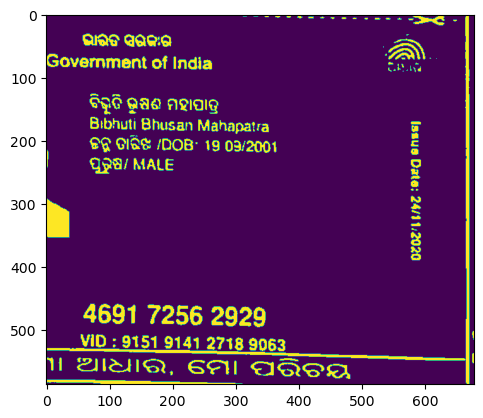

In [3]:
image = cv2.imread("../assets/aadhaar/bibhu.jpg")
# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Gaussian blur
blur = cv2.GaussianBlur(gray, (3, 3), 0)
# Otsu's threshold
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Morph open to remove noise and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
invert = 255 - opening

# Perform text extraction
current_processing_image = thresh
# data = pytesseract.image_to_string(invert, lang="eng", config="--psm 6")
data = pytesseract.image_to_string(current_processing_image, lang="eng", config="--psm 4")
print(data)

text = data.replace("\n", " new_line ")
print('TEXT: ', text)
# Show image
plt.imshow(current_processing_image)

In [4]:
def extract_data(text):
    # init variables
    splitted_text = []
    aadhaar_no = None
    name = None
    dob = None
    gender = None

    for txt in text.split('new_line'):
        txt = txt.strip()
        if txt:
            splitted_text.append(txt);

    print('splitted text: ', splitted_text)
    print("\n-----------\n")

    # Date of Birth and Name
    if dob is None:
        dob_match = re.search('[0-9]{2}/[0-9]{2}/[0-9]{2,4}', text)
        if dob_match:
            # DOB
            dob = dob_match.group(0)
            # Name
            if dob:
                dob_index = next((i for i, s in enumerate(splitted_text) if dob in s), -1)
                name_match = re.search("[A-Za-z ]{2,}", splitted_text[dob_index - 1])
                if name_match:
                    name = name_match.group(0).strip()

    # Aadhaar Number
    if aadhaar_no is None:
        aadhaar_no_match = re.search('[0-9]{4} [0-9]{4} [0-9]{4}', text);
        if aadhaar_no_match:
            aadhaar_no = aadhaar_no_match.group(0)
            #   TODO: Cross-verify: o/p -> split -> arr.len == 3 && arr[i].len == 4 && number

    # Gender
    if gender is None:
        gender_match = re.search('(male|female)', text.lower())
        if(gender_match):
            gender = gender_match.group(0)

    output = {
        'name': name,
        'aadhaarNumber': aadhaar_no,
        'dob': dob,
        'gender': gender
    }

    print('OUTPUT', output)

    if name is None or dob is None or aadhaar_no is None or gender is None:
        images= [gray, thresh, blur, image]
        for image_format in images:
            data = pytesseract.image_to_string(image_format, lang="eng", config="--psm 4")
            text = data.replace("\n", " new_line ")
            return extract_data(text)
    
    return output

In [6]:
op = extract_data(text)
print('OP',op)

splitted text:  ['alae Gace A.', 'Government of India fein', 'Gg aaa Agialg', 'Bibhuti Bhusan Mahapatra Fy', 'SE GIRS /DOB- 19 09/2001 &', '} pay MALE 2', '4', 'a ;', '8', '4691 7256 2929', 'VID : 9151 9141 2718 9063', 'HU Ze, GA ARed']

-----------

OUTPUT {'name': None, 'aadhaarNumber': '4691 7256 2929', 'dob': None, 'gender': 'male'}
splitted text:  ['Aas Aawia', 'Government of India Ga', 'SQe aaa Agiaig', 'Bibhuti Bhusan Mahapatra =', '@ SIS /DOB: 19/09/2001 &', '} gay MALE 9', '4691 7256 2929', 'VID : 9151 9141 2718 9063', 'MW ZUR, GAL ARG']

-----------

OUTPUT {'name': 'Bibhuti Bhusan Mahapatra', 'aadhaarNumber': '4691 7256 2929', 'dob': '19/09/2001', 'gender': 'male'}
OP {'name': 'Bibhuti Bhusan Mahapatra', 'aadhaarNumber': '4691 7256 2929', 'dob': '19/09/2001', 'gender': 'male'}
